In [1]:
# Core
import datetime
import os
import glob
import tempfile
import sys
import pickle
import copy

# Analysis 
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt

# Debugging 
import pdb, traceback
%load_ext line_profiler

# Radar Tools
import pyart
import tint
from tint import animate
from tint.visualization import plot_tracks_horiz_cross

# CPOL convenience functions
import CPOL_func as cf


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/563/esh563/pyart/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/563/esh563/pyart/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [5]:
filenames = cf.load_wet_seasons(years=list(range(2002,2016)))

Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.
Gathering files.


In [ ]:
cf.get_CPOL_tracks(2001)

Gathering files.
No objects found in scan 12.    
Time discontinuity at 2001-11-01 04:10:01.
No objects found in scan 17.    
Time discontinuity at 2001-11-01 05:20:00.
No objects found in scan 152.    
Time discontinuity at 2001-11-02 04:10:01.
No objects found in scan 166.    
Time discontinuity at 2001-11-02 06:50:00.
Writing tracks for scan 723.     
Time discontinuity at 2001-11-06 04:10:00.
Writing tracks for scan 732.    
Time discontinuity at 2001-11-06 07:30:01.
Writing tracks for scan 736.    
Time discontinuity at 2001-11-06 19:09:49.
No objects found in scan 1414.    
Time discontinuity at 2001-11-11 13:00:01.
No objects found in scan 2632.    
Time discontinuity at 2001-11-20 03:50:00.
No objects found in scan 2757.    
Time discontinuity at 2001-11-21 04:00:00.
No objects found in scan 2779.    
Time discontinuity at 2001-11-21 13:19:51.
No objects found in scan 2988.    
Time discontinuity at 2001-11-23 02:00:02.
Writing tracks for scan 3297.     
Time discontinuity at 2

In [2]:
def test():
    filenames = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-10 08:00'), 
                  np.datetime64('2006-02-10 16:00'), 
                  np.timedelta64(10, 'm'))
    )[0]

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/circ_b_ind_set.pkl', 
              'rb') as f:
        b_ind_set = pickle.load(f)

    # Define settings for tracking
    settings = {
        'MIN_SIZE' : [40, 400, 800], # square km
        'FIELD_THRESH' : ['convective', 20, 15], # DbZ
        'ISO_THRESH' : [10, 10, 10], # DbZ
        'GS_ALT' : 3000,
        'SEARCH_MARGIN' : 10000, # m. This is just for object matching step:
        # does not affect flow vectors.
        'FLOW_MARGIN' : 40000, # m. Margin around object over which to
        # perform phase correlation.
        'LEVELS' : np.array( # m
            [[3000, 3500], 
             [3500, 7500],
             [7500, 10000]]
        ),
        'TRACK_INTERVAL' : 0,
        'BOUNDARY_GRID_CELLS' : b_ind_set,
        'UPDRAFT_START': 3000
    }

    tracks_obj  = tint.Cell_tracks()

    for parameter in ['MIN_SIZE', 'FIELD_THRESH', 'GS_ALT', 'LEVELS', 
                      'TRACK_INTERVAL', 'ISO_THRESH', 'SEARCH_MARGIN',
                      'FLOW_MARGIN', 'BOUNDARY_GRID_CELLS', 'UPDRAFT_START'
                     ]:
        tracks_obj.params[parameter] = settings[parameter]

    # Calculate tracks
    # %lprun -T lprof0 -f get_filtered_frame_steiner tracks_obj.get_tracks(grids)
    tracks_obj.get_tracks(grids)
    tracks_obj = cf.get_reanalysis_vars(tracks_obj)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    out_file_name = ('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/'
                     + 'tracks_obj_monash.pkl'.format(dt))

    with open(out_file_name, 'wb') as f:
        pickle.dump(tracks_obj, f)
        
    return tracks_obj
        
if __name__ == '__main__':
    try:
        tracks_obj = test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)
        
# print(open('lprof0', 'r').read())

Gathering files.
Calculating additional tracks properties.
Calculating system tracks.


Time elapsed: 0.2 minutes
Adding data from Monash Reanalysis
Input already a dataframe.
Input already a dataframe.
Input already a dataframe.


In [2]:
with open('/g/data/w40/esh563/CPOL_analysis/TINT_tracks/tracks_obj_test.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [34]:
6.5/2.5

2.6

In [31]:
ud = tracks_obj.system_tracks['updrafts']
ud_tilt = []
for i in range(len(ud)):
    ud_i = tracks_obj.system_tracks['updrafts'].iloc[i]
    ud_tilt_i = []
    for j in range(len(ud_i)):
        ud_tilt_i_j = (ud_i[j][-1]-ud_i[j][0])*(.5, 2.5, 2.5)
        ud_tilt_i.append(ud_tilt_i_j)
    ud_tilt.append(ud_tilt_i)
ud_tilt

[[array([6.5, 0. , 2.5]),
  array([ 15.5, -12.5,   5. ]),
  array([14. , -7.5,  2.5]),
  array([ 8.5, -2.5,  0. ]),
  array([8., 0., 0.]),
  array([8. , 2.5, 0. ])],
 [array([ 6. , -2.5,  0. ]),
  array([4., 0., 0.]),
  array([ 2.5, -2.5,  0. ]),
  array([ 6. , -2.5,  0. ]),
  array([ 7. , -2.5, -2.5]),
  array([10.5,  0. ,  0. ]),
  array([5., 0., 0.])],
 [array([ 3.5, -2.5,  0. ]),
  array([13. , -7.5,  0. ]),
  array([ 15. , -12.5,  -2.5]),
  array([15. , -5. ,  2.5]),
  array([6., 0., 0.]),
  array([ 6.5, -2.5,  0. ])],
 [array([ 5.5,  0. , -2.5]), array([4., 0., 0.]), array([11.5,  2.5,  0. ])],
 [array([14.5, -2.5,  7.5]),
  array([4.5, 0. , 2.5]),
  array([6.5, 2.5, 2.5]),
  array([1., 0., 0.]),
  array([9.5, 0. , 5. ]),
  array([9.5, 0. , 0. ])],
 [array([4.5, 0. , 0. ]),
  array([5., 0., 0.]),
  array([ 6. ,  0. , -2.5]),
  array([12.5,  2.5,  0. ])],
 [array([ 2.5,  0. , -2.5]),
  array([ 3.5,  0. , -2.5]),
  array([1.5, 0. , 0. ]),
  array([7. , 0. , 2.5]),
  array([ 7.5, -2

Gathering files.
Animating 12 frames
Plotting frame at 2006-02-10T09:00:09
Plotting updraft 5.  
Creating GIF - may take a few minutes.


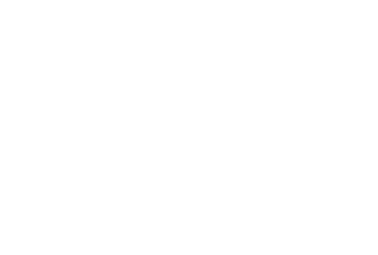

In [30]:
def test():
    uid = '0'

#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(
#         tracks_obj, uid
#     )

    lon_min = 131.0 - 2.6
    lon_max = 131.0 + 2.6

    lat_max = -12.2 + 2.6
    lat_min = -12.2 - 2.6
    
    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-10 09:00'), 
        np.datetime64('2006-02-10 09:10'), 
        np.timedelta64(10, 'm')))

    grids = (pyart.io.read_grid(fn) for fn in filenames)  # refresh grid generator

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")
    
    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_lagrangian'
    animate(tracks_obj, grids, out_path, style='updraft', uid=uid, 
            alt_low=3000, alt_high=10000, keep_frames=False, dpi=100,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2), 
            center_ud=True, updraft_ind=None)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

In [6]:
def test():
    lon_min = 131.0 - 1.6
    lon_max = 131.0 + 1.6

    lat_max = -12.2 + 1.6
    lat_min = -12.2 - 1.6

    [filenames, start_time, end_time] = cf.CPOL_files_from_datetime_list(
        np.arange(np.datetime64('2006-02-10 09:00'), 
                  np.datetime64('2006-02-10 14:50'), 
                  np.timedelta64(10, 'm'))
    )
    
    tracks_obj_temp = copy.deepcopy(tracks_obj)
#     tracks_obj_temp.tracks = tracks_obj_temp.tracks[sub_cond]
#     tracks_obj_temp.system_tracks = tracks_obj_temp.system_tracks[sub_cond_sys]
    
#     filenames, start_time, end_time = cf.CPOL_files_from_TINT_obj(
#         tracks_obj_temp, '7079'
#     )

    # Generate grid generator 
    # Note generators produce iterators
    # These are alternative to using lists and looping
    grids = (pyart.io.read_grid(fn, include_fields = 'reflectivity')
             for fn in filenames)

    # Create directory for figures
    dt=str(datetime.datetime.now())[0:-7]
    dt=dt.replace(" ", "_")
    dt=dt.replace(":", "_")
    dt=dt.replace("-", "")

    base_path = '/g/data/w40/esh563/CPOL_analysis/figures/TINT/'
    out_path = base_path + dt + '_tint_CPOL_anim'

    animate(tracks_obj_temp, grids, out_path,
            start_datetime = start_time,
            end_datetime = end_time,
            lat_lines=np.arange(lat_min, lat_max, .2),
            lon_lines=np.arange(lon_min, lon_max, .2),
            tracers=False, keep_frames=False, dpi=100, alt_low=3000,
            alt_high=9500, scan_boundary=False)
    
if __name__ == '__main__':
    try:
        test()
    except:
        extype, value, tb = sys.exc_info()
        traceback.print_exc()
        pdb.post_mortem(tb)

Gathering files.
Animating from 2006-02-10T09:00 to 2006-02-10T14:40.
Plotting scan at 2006-02-10T14:30:09.
Reached 2006-02-10T14:40.
Breaking loop.

Creating GIF - may take a few minutes.


In [11]:
# Let's filter by tilt direction and magnitude, velocity magnitude
# and significant area.
eastward_motion = (tracks_obj.system_tracks['u_shift'] > 5)
forward_tilt = ((-45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 45))
backward_tilt = ((-135 >= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                | (tracks_obj.system_tracks['sys_rel_tilt_dir'] >= 135))
left_tilt = ((45 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= 135))
right_tilt = ((-135 <= tracks_obj.system_tracks['sys_rel_tilt_dir'])
                & (tracks_obj.system_tracks['sys_rel_tilt_dir'] <= -45))
# # downshear_motion = ((-45 <= tracks_obj.system_tracks['shear_rel_sys_dir'])
# #                 & (tracks_obj.system_tracks['shear_rel_sys_dir'] <= 45))
# # upshear_motion = ((-135 >= tracks_obj.system_tracks['shear_rel_sys_dir'])
# #                  | (tracks_obj.system_tracks['shear_rel_sys_dir'] >= 135))
# sig_shear_mag = (tracks_obj.system_tracks['shear_mag'] >= 2)
sig_tilt_mag = (tracks_obj.system_tracks['tilt_mag'] >= 20000)
vel_mag = np.sqrt(tracks_obj.system_tracks['u']**2 
                  + tracks_obj.system_tracks['v']**2)
sig_vel_mag = ((vel_mag >= 5) & (vel_mag <= 40))
eccentricity_mag = tracks_obj.system_tracks['eccentricity'] > .85
# Note for CPOL 2.5 km, total scan area is only 66052 km^2. This makes 
# traditional MCS definitions of area > 30000 km^2 difficult to apply, 
# and still coherently calculate tilt. 
sig_area = ((tracks_obj.system_tracks['proj_area'] >= 4000) & 
            (tracks_obj.system_tracks['proj_area'] <= 50000))
not_border = (tracks_obj.system_tracks['touch_border']*6.25 / tracks_obj.system_tracks['proj_area']) < 0.01

tracks_0 = tracks_obj.tracks[['touch_border', 'proj_area']].xs(
    0, level='level'
)
not_border_0 = (tracks_0['touch_border'] * 6.25 / tracks_0['proj_area']) < 0.01

In [15]:
# Let's find the cells that were tracked for the most frames.
sub_cond_sys = sig_tilt_mag & sig_vel_mag & sig_area & not_border & not_border_0
sub_cond = sub_cond_sys.append([sub_cond_sys]*2).sort_index(sort_remaining=True)
levels = np.array([0,1,2]*len(sub_cond_sys))

sub_cond = sub_cond.to_frame()
sub_cond.insert(0, 'level', levels)
sub_cond = sub_cond.reset_index()

sub_cond = sub_cond.set_index(['scan', 'time', 'level', 'uid'])
# sub_cond = sub_cond.ix[:,0]
# tracks_obj.tracks[sub_cond]
tracks_obj.system_tracks[sub_cond_sys].groupby(level='uid').size().sort_values(ascending=False)[:20]

uid
14809    32
5260     31
2986     28
824      25
4948     25
9585     24
14960    23
3115     23
5662     23
11065    22
5874     22
9102     22
5545     22
7365     21
13851    21
5502     21
2834     21
3619     20
11020    20
9663     20
dtype: int64

In [14]:
tracks_obj.system_tracks[sub_cond_sys].xs('5732', level='uid')['proj_area']

scan   time               
52165  2003-01-24 17:50:00    12137.50
52166  2003-01-24 18:00:00    12118.75
52167  2003-01-24 18:10:03    11450.00
52169  2003-01-24 18:30:01    10712.50
52171  2003-01-24 18:50:00     9662.50
52172  2003-01-24 19:00:00     8337.50
52173  2003-01-24 19:10:03     4225.00
Name: proj_area, dtype: float64

# Calculate Some Statistics

In [34]:
subset_logic = sig_area & not_border & sig_vel_mag & sig_tilt_mag & not_border_0 & eccentricity_mag

sub_tracks = tracks_obj.system_tracks[subset_logic]
sub_uids = list(sorted(set([int(sub_tracks.index.values[i][2]) for i in range(len(sub_tracks))])))
sub_uids = [str(i) for i in sub_uids]

MCS_lengths = [len(sub_tracks.xs(i, level='uid').reset_index(level='time').index.values) for i in sub_uids]

max_MCS = max(MCS_lengths)

# Create 3 lists with lengths the lifetime of longest object.
[TS, LS, PS] = [np.zeros(80) for i in range(3)]

for i in sub_uids:
    obj = sub_tracks.xs(i, level='uid').reset_index(level='time')
    scans = obj.index.values
    scan_label = scans - min(scans)
    tilts = obj['sys_rel_tilt_dir']

    forward_tilt = ((-45 <= tilts) & (tilts <= 45))
    backward_tilt = ((-135 >= tilts) | (tilts >= 135))

    fwd_inds = scan_label[np.argwhere(forward_tilt).flatten().tolist()].tolist()
    bwd_inds = scan_label[np.argwhere(backward_tilt).flatten().tolist()].tolist()
    pll_inds = scan_label[np.argwhere(~backward_tilt & ~forward_tilt).flatten().tolist()].tolist()

    TS[bwd_inds] += 1
    LS[fwd_inds] += 1
    PS[pll_inds] += 1

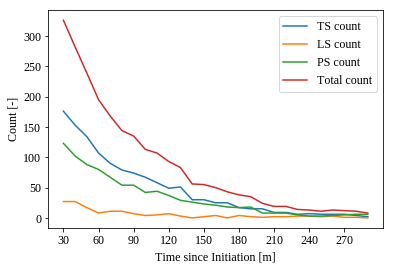

In [35]:
plt.plot(np.arange(30,300,10), TS[3:30], label='TS count')
plt.plot(np.arange(30,300,10), LS[3:30], label='LS count')
plt.plot(np.arange(30,300,10), PS[3:30], label='PS count')
plt.plot(np.arange(30,300,10), (TS+PS+LS)[3:30], label='Total count')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Count [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/counts.png')

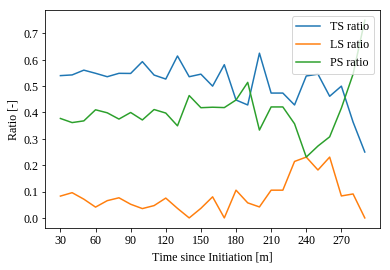

In [36]:
tot = (TS+PS+LS)

plt.plot(np.arange(30,300,10), (TS/tot)[3:30], label='TS ratio')
plt.plot(np.arange(30,300,10), (LS/tot)[3:30], label='LS ratio')
plt.plot(np.arange(30,300,10), (PS/tot)[3:30], label='PS ratio')
plt.xticks(np.arange(30,300,30))
plt.ylabel('Ratio [-]')
plt.xlabel('Time since Initiation [m]')
plt.legend()
# Note that we don't really know the start times of the systems!
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/TINT/ratios.png')